In [17]:
import pandas as pd
import xarray as xr
import numpy as np
import scipy.stats as stats
import requests
import rasterio
from rasterio.plot import show
import richdem as rd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import matplotlib.pyplot as plt


In [18]:
# Download a DEM 

# Your OpenTopography API key
OPENTOPO_API_KEY = "f95f74790401d94ee1989cd4cffea1d7"

# Define the bounding box for the area of interest
min_lon, min_lat = -111.5, 36.5
max_lon, max_lat = -102.5, 41.5

# OpenTopography API URL
url = "https://portal.opentopography.org/API/globaldem"

# Parameters for the API request
params = {
    'demtype': 'SRTMGL1',  # You can choose other DEM types like 'SRTMGL3', 'AW3D30', etc.
    'south': min_lat,
    'north': max_lat,
    'west': min_lon,
    'east': max_lon,
    'outputFormat': 'GTiff',
    'API_Key': OPENTOPO_API_KEY
}

# Make the API request
response = requests.get(url, params=params)

# Save the DEM file
dem_path = 'dem2.tif'
with open(dem_path, 'wb') as f:
    f.write(response.content)

with rasterio.open(dem_path) as src:
    # Calculate the window to read based on the desired coordinates
    window = rasterio.windows.from_bounds(min_lon, min_lat, max_lon, max_lat, transform=src.transform)
    dem = src.read(1, window=window)
    transform = src.window_transform(window)


In [5]:
dem

array([[2694, 2698, 2703, ..., 1147, 1145, 1144],
       [2691, 2696, 2700, ..., 1148, 1146, 1144],
       [2689, 2694, 2698, ..., 1148, 1147, 1146],
       ...,
       [1938, 1937, 1936, ..., 1248, 1245, 1243],
       [1938, 1936, 1937, ..., 1246, 1245, 1243],
       [1938, 1939, 1941, ..., 1245, 1244, 1244]],
      shape=(18000, 32400), dtype=int16)

In [6]:
dem = rd.LoadGDAL('dem2.tif')
dem

rdarray([[2694, 2698, 2703, ..., 1147, 1145, 1144],
         [2691, 2696, 2700, ..., 1148, 1146, 1144],
         [2689, 2694, 2698, ..., 1148, 1147, 1146],
         ...,
         [1938, 1937, 1936, ..., 1248, 1245, 1243],
         [1938, 1936, 1937, ..., 1246, 1245, 1243],
         [1938, 1939, 1941, ..., 1245, 1244, 1244]],
        shape=(18000, 32400), dtype=int16)

In [112]:
14400 / 20

720.0

In [113]:
39600 / 36

1100.0

In [12]:
len(dem)

14400

In [7]:
elev_data = []
row_arr = np.array_split(dem, 20)
#print(row_arr)
for arr in row_arr:
    col_arr = np.array_split(arr, 36, axis = 1)
    row_means = []
    for arr in col_arr:
        row_means.append(float(np.mean(arr)))
    row_means.reverse()
    elev_data.append(row_means)

In [117]:
len(elev_data)

20

In [118]:
len(elev_data[0])
#np.mean(elev_data)

36

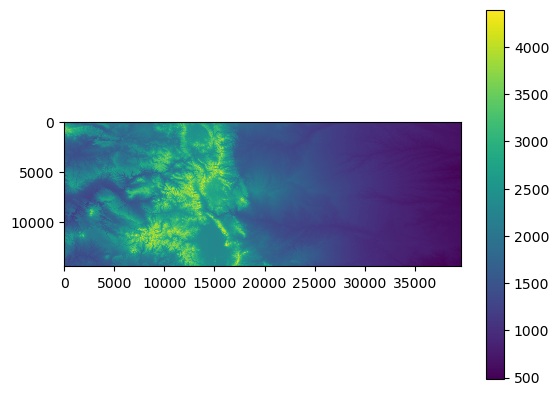

In [27]:
plt.imshow(dem, interpolation='none')
plt.colorbar()
plt.show()

In [8]:
precip_data = xr.open_dataset("../Data/Colorado_accum.nc")
precip_data
inst_data = xr.open_dataset("../Data/Colorado_instant.nc")
inst_data

<xarray.Dataset> Size: 11MB
Dimensions:     (valid_time: 672, latitude: 29, longitude: 45)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 5kB 2025-02-01 ... 2025-02-28T23:...
  * latitude    (latitude) float64 232B 42.5 42.25 42.0 ... 36.0 35.75 35.5
  * longitude   (longitude) float64 360B -111.5 -111.2 -111.0 ... -100.8 -100.5
    expver      (valid_time) <U4 11kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 4MB ...
    v10         (valid_time, latitude, longitude) float32 4MB ...
    t2m         (valid_time, latitude, longitude) float32 4MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-18T22:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
avalanche_data = pd.read_csv("../Data/avalanche_colorado.csv")
avalanche_data['Date'] = avalanche_data['Date'].str.split(' GMT').str[0]
avalanche_data['Date'] = pd.to_datetime(avalanche_data['Date'])
avalanche_data['Date'] = avalanche_data['Date'].dt.strftime('%b %d')
avalanche_data = avalanche_data.loc[:, ["Date", "Longitude", "latitude"]]
avalanche_data = avalanche_data[avalanche_data['Date'] == 'Feb 25']
avalanche_data

,Date,Longitude,latitude
41,Feb 25,-106.926922,39.168065
42,Feb 25,-107.792203,37.908853
43,Feb 25,-107.843197,37.853397
44,Feb 25,-106.388902,39.022677
45,Feb 25,-105.724746,39.599387
46,Feb 25,-106.180301,39.463320
47,Feb 25,-108.039188,37.449961
48,Feb 25,-106.558147,39.082909
49,Feb 25,-106.558147,39.082909
50,Feb 25,-105.869044,39.833220


In [10]:
lon_min = precip_data['longitude'].min().item()
lon_max = precip_data['longitude'].max().item()
lat_min = precip_data['latitude'].min().item()
lat_max = precip_data['latitude'].max().item()

lon_edges = np.arange(lon_max, lon_min - 0.25, -0.25)
lat_edges = np.arange(lat_min, lat_max + 0.25, 0.25)

lon_edges

array([-100.5 , -100.75, -101.  , -101.25, -101.5 , -101.75, -102.  ,
       -102.25, -102.5 , -102.75, -103.  , -103.25, -103.5 , -103.75,
       -104.  , -104.25, -104.5 , -104.75, -105.  , -105.25, -105.5 ,
       -105.75, -106.  , -106.25, -106.5 , -106.75, -107.  , -107.25,
       -107.5 , -107.75, -108.  , -108.25, -108.5 , -108.75, -109.  ,
       -109.25, -109.5 , -109.75, -110.  , -110.25, -110.5 , -110.75,
       -111.  , -111.25, -111.5 ])

In [11]:
lat_edges

array([35.5 , 35.75, 36.  , 36.25, 36.5 , 36.75, 37.  , 37.25, 37.5 ,
       37.75, 38.  , 38.25, 38.5 , 38.75, 39.  , 39.25, 39.5 , 39.75,
       40.  , 40.25, 40.5 , 40.75, 41.  , 41.25, 41.5 , 41.75, 42.  ,
       42.25, 42.5 ])

In [12]:
avalanche_count = []
precip_by_cell = []
rad_by_cell = []
temp_by_cell = []
u10_by_cell = []
v10_by_cell = []
elev_by_cell = []

for i in range(len(lon_edges) - 1):
    for j in range(len(lat_edges) - 1):
        count = len(avalanche_data[((avalanche_data['latitude'] >= lat_edges[j]) & (avalanche_data['latitude'] <= lat_edges[j+1])) &
                                   ((avalanche_data['Longitude'] <= lon_edges[i]) & (avalanche_data['Longitude'] >= lon_edges[i+1]))])
        avalanche_count.append(count)
        precip_by_cell.append(precip_data['tp'].sel(valid_time='2025-02-25', latitude=lat_edges[j], longitude=lon_edges[i], method='nearest').item())
        rad_by_cell.append(precip_data['ssrd'].sel(valid_time='2025-02-25', latitude=lat_edges[j], longitude=lon_edges[i], method='nearest').item())
        temp_by_cell.append(inst_data['t2m'].sel(valid_time='2025-02-25', latitude=lat_edges[j], longitude=lon_edges[i], method='nearest').item())
        u10_by_cell.append(inst_data['u10'].sel(valid_time='2025-02-25', latitude=lat_edges[j], longitude=lon_edges[i], method='nearest').item())
        v10_by_cell.append(inst_data['v10'].sel(valid_time='2025-02-25', latitude=lat_edges[j], longitude=lon_edges[i], method='nearest').item())
        if ((i-2 >= 0 and i-2 < 35) and (j-2 >= 0 and j-2 < 19)):
            elev_by_cell.append(elev_data[j-2][i-6])
        else:
            elev_by_cell.append(2075.753230282922)

In [13]:
df = pd.DataFrame({'avalanche_count': avalanche_count, 'precip': precip_by_cell, 'rad': rad_by_cell, 'temp': temp_by_cell, 'u10': u10_by_cell, 'v10': v10_by_cell, 'elev': elev_by_cell})
df['rad'] /= 3600
df['elev'] /= 1000
#df['temp'] = (df['temp'] - 272.15) * 1.8 + 32 # Convert Kelvin to Fahrenheit
df

,avalanche_count,precip,rad,temp,u10,v10,elev
0,0,0.0,163.502222,291.786377,-1.314651,-2.487442,2.075753
1,0,0.0,162.275556,290.860596,-1.636917,-2.184708,2.075753
2,0,0.0,160.764444,290.764893,-2.111526,-1.845840,2.075753
3,0,0.0,159.040000,290.614502,-2.369339,-1.544083,2.075753
4,0,0.0,156.764444,290.901611,-2.572464,-1.419083,2.075753
...,...,...,...,...,...,...,...
1227,0,0.0,291.448889,280.706299,1.046677,1.882675,2.075753
1228,0,0.0,292.693333,280.094971,1.568161,1.592636,2.075753
1229,0,0.0,289.137778,278.509033,1.956833,1.345566,2.075753
1230,0,0.0,279.182222,280.848877,0.937302,0.408066,2.075753


In [14]:
def model_parameters(reg, columns):
    """Returns a string with the linear regression model parameters for the given column names."""
    slopes = [f"{coef:.2f}({columns[i]})" for i, coef in enumerate(reg.coef_)]
    return " + ".join([f"{reg.intercept_:.2f}"] + slopes)

predictors = ['precip', 'rad', 'temp', 'u10', 'v10', 'elev']  
outcome = 'avalanche_count'

X = df[predictors]
y = df[outcome]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # 80% training, 20% testing

model = LinearRegression().fit(X_train, y_train)
#model = LinearRegression().fit(df.loc[:, ['precip', 'rad', 'temp', 'u10', 'v10']], df['avalanche_count'])

print("Model:", model_parameters(model, X_train.columns))
print("Error:", root_mean_squared_error(y_test, model.predict(X_test)))

print("Model Coefficients:")
for feature, coef in zip(predictors, model.coef_):
    print(f"{feature:10s}: {coef:.4f}") 

Model: 1.38 + -81540.46(precip) + 0.00(rad) + -0.00(temp) + -0.00(u10) + -0.01(v10) + 0.01(elev)
Error: 0.025578470365073307
Model Coefficients:
precip    : -81540.4602
rad       : 0.0001
temp      : -0.0049
u10       : -0.0028
v10       : -0.0078
elev      : 0.0097


In [15]:
for predict in predictors:
    print("\n" + str(predict) + ": ")
    print(pg.corr(df[predict], df['avalanche_count']))
#pg.corr(df['precip'], df['avalanche_count'])


precip: 
            n         r          CI95%     p-val   BF10     power
pearson  1232 -0.008318  [-0.06, 0.05]  0.770531  0.037  0.059792

rad: 
            n         r          CI95%     p-val   BF10     power
pearson  1232  0.037048  [-0.02, 0.09]  0.193773  0.083  0.255131

temp: 
            n         r          CI95%         p-val       BF10     power
pearson  1232 -0.143989  [-0.2, -0.09]  3.868299e-07  1.378e+04  0.999111

u10: 
            n         r          CI95%     p-val  BF10     power
pearson  1232  0.032995  [-0.02, 0.09]  0.247171  0.07  0.212047

v10: 
            n         r          CI95%     p-val   BF10     power
pearson  1232 -0.008331  [-0.06, 0.05]  0.770194  0.037  0.059821

elev: 
            n         r         CI95%     p-val   BF10     power
pearson  1232  0.092188  [0.04, 0.15]  0.001198  6.739  0.900127


In [16]:
model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
results = model.fit()

print(results.summary())
print(results.pvalues)


                 Generalized Linear Model Regression Results                  
Dep. Variable:        avalanche_count   No. Observations:                  985
Model:                            GLM   Df Residuals:                      979
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49.659
Date:                Thu, 01 May 2025   Deviance:                       80.090
Time:                        21:42:06   Pearson chi2:                     507.
No. Iterations:                    19   Pseudo R-squ. (CS):            0.02441
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
precip     -3.755e+07   2.56e+10     -0.001      0.9